## Model Evaluation for FRCNN

## This is the inference file for FRCNN model

#### A pre trained ResNet50 with fpn backbone was used for model training. The model is performing good with limited size data. The objective is to modify this architecture for achiveing higher map accuracy in future experiments.

In [ ]:
import torch
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import numpy as np
import cv2
#from model import load_model, DEVICE, CONF_THRESH

In [ ]:
# For GPU accelartion the inference.py was trained on Google collab A1000 40GB GPU

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  -----------------------------------------------------------------
##  pretrained resnet50 was used for Faster RCNN base line training
##  Objectve is to improve the perfomance in next architecture
##  Attention modules to be implemented in further experiments
##  This code is referneced from Pytorch - torchvision documentations
##  -------------------------------------------------------------------


def build_resnet50_frcnn(num_classes):
    backbone = resnet_fpn_backbone(
        backbone_name="resnet50",
        weights=torchvision.models.ResNet50_Weights.DEFAULT,
        trainable_layers=3
    )
    model = FasterRCNN(backbone=backbone, num_classes=num_classes)
    return model.to(DEVICE)


def print_model_size(model):
    total_pars = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_pars}")
    return


def collate_fn(batch):
    from torchvision.transforms import ToTensor
    images, targets = tuple(zip(*batch))
    images = [ToTensor()(img) for img in images]
    return images, targets


In [21]:
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt


## -----------------------------------------
## Pytesseract OCR wasnused to extract text
## -----------------------------------------

def run_inference_with_ocr(image_path, model, conf_threshold=0.5):
    image = Image.open(image_path).convert("RGB")                                 ## --------------------------------------
    image_tensor = F.to_tensor(image).unsqueeze(0).to(DEVICE)                     ## inference with ocr suppored conversion
                                                                                  ## ---------------------------------------
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    boxes = predictions['boxes']
    scores = predictions['scores']

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    extracted_texts = []

    for box, score in zip(boxes, scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = map(int, box.tolist())
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

            # Crop box for OCR readble
            plate = image.crop((x1, y1, x2, y2))

            # Enhancement for better readbility by OCR
            plate = plate.resize((plate.width * 2, plate.height * 2), Image.BICUBIC)
            plate = plate.convert("L")

            text = pytesseract.image_to_string(plate, config="--psm 7")
            extracted_texts.append(text.strip())

            # Draw label on image
            draw.text((x1, y1 - 10), text.strip(), fill="red", font=font)

    return image, extracted_texts




def run_and_display(image_path, model):
    result_img, plate_texts = run_inference_with_ocr(image_path, model)

    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis("off")
    plt.title("Detected Number Plate(s)")
    plt.show()

    print("\nExtracted Texts:")
    for i, text in enumerate(plate_texts):
        print(f"Plate {i+1}: {text}")


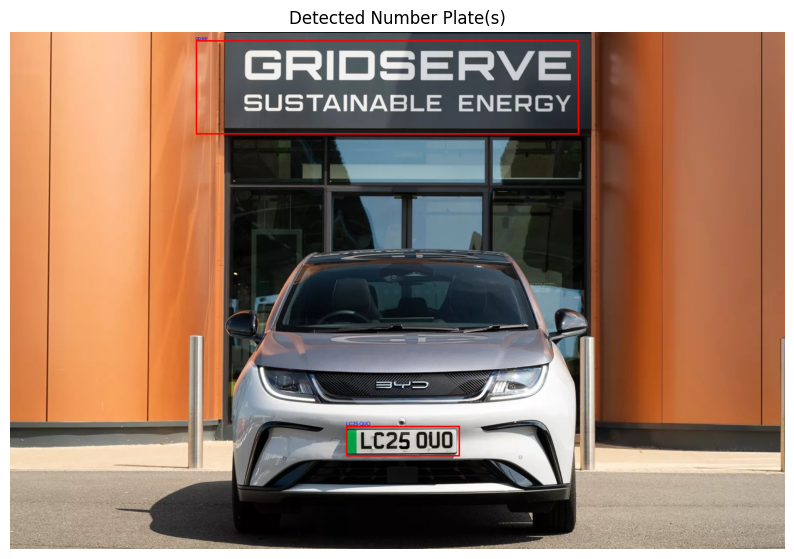


Extracted Texts:
Plate 1: LC25 QUO
Plate 2: oo ee


In [22]:
MODEL_PATH = "/content/frcnn_best.pth"
model = load_model(MODEL_PATH)
run_and_display("//content/car1.jpg", model)


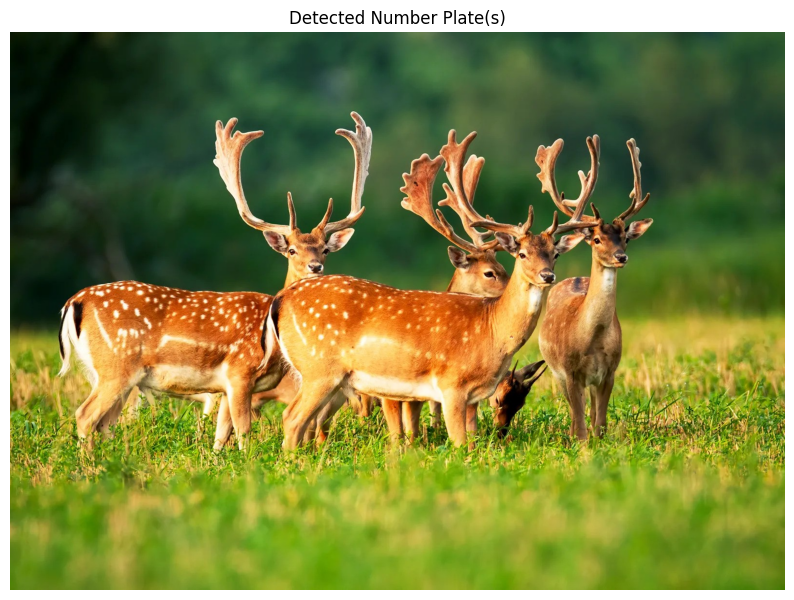


Extracted Texts:


In [15]:
MODEL_PATH = "/content/frcnn_best.pth"
model = load_model(MODEL_PATH)
run_and_display("/content/animal.jpg", model)


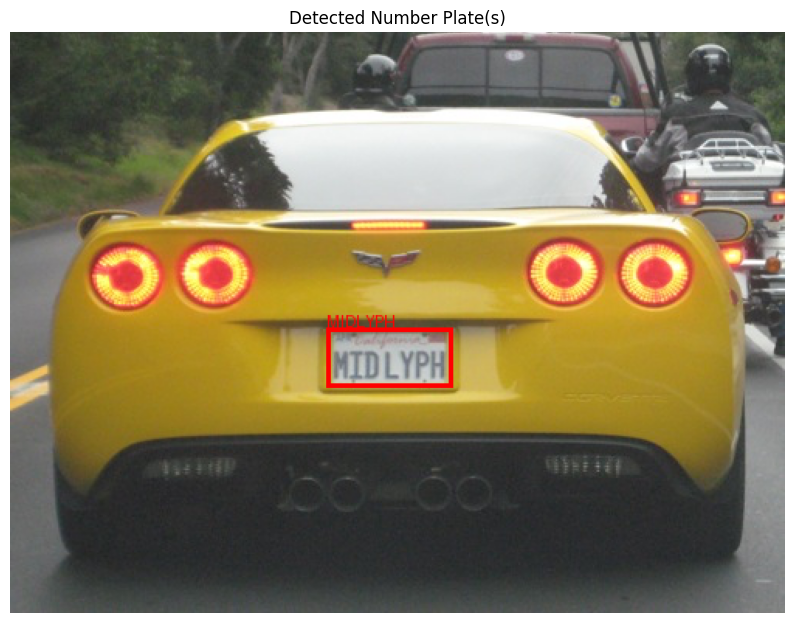


Extracted Texts:
Plate 1: MIDLYPH


In [18]:
MODEL_PATH = "/content/frcnn_best.pth"
model = load_model(MODEL_PATH)
run_and_display("/content/Cars36.png", model)

/usr/bin/tesseract
